#Introduction

The purpose of this notebook is to develop an image classification algorithm that classifies images into one of at least two categories.

#The Data

The dataset used will be the MNIST that contains handwritten digits from 1 - 9. The link to the data can be found here: https://www.kaggle.com/datasets/hojjatk/mnist-dataset


Import all necessary packages for the analysis.

In [51]:
!pip install keras_tuner

In [52]:
# Import all necessary packages for the analysis.
import keras
from keras.datasets import mnist
import keras_tuner
from keras import layers
from keras import layers, regularizers
from keras.optimizers.legacy import Adam
from keras.callbacks import EarlyStopping, TensorBoard
import json
from sklearn.metrics import confusion_matrix
from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import numpy as np
from array import array
from os.path  import join
from sklearn.linear_model import LogisticRegression
%matplotlib inline
import random
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load the dataset from the Keras package.

In [53]:
# Load MINST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Create a fuction that will examine and show some of the contents/pictures we're working with.

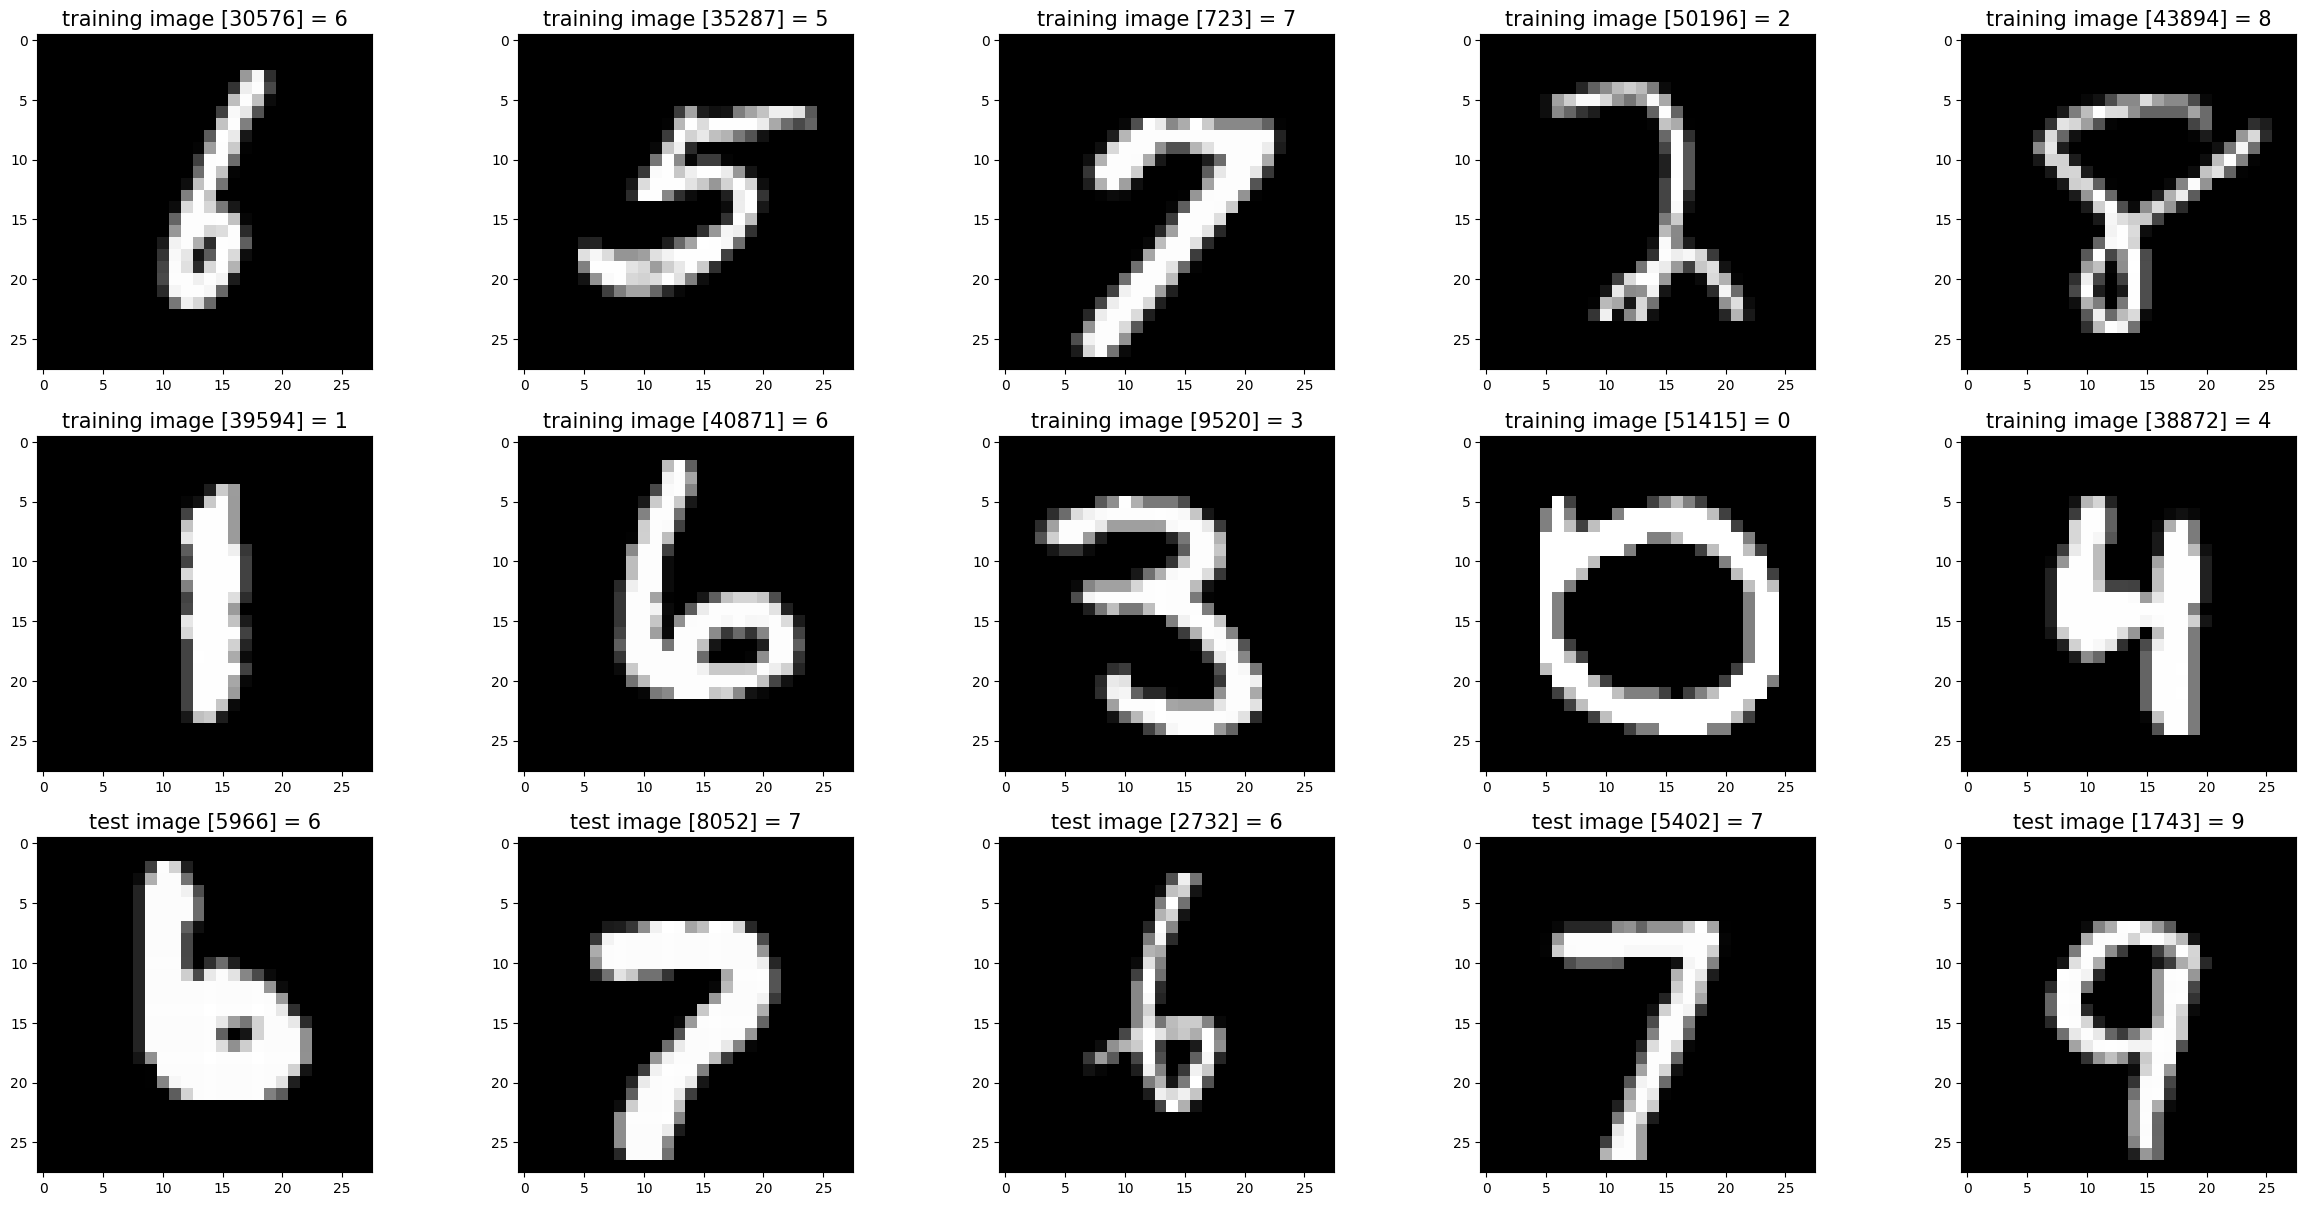

In [54]:
# Function to show a list of images with their relating titles so we can examine the contents of the dataset.
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1

# Use the fuction to show some random training and test images
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))

show_images(images_2_show, titles_2_show)

Examine the shape of the dataset and convert all the pictures to a 1D array.

In [55]:
x_train.shape

(60000, 28, 28)

In [56]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_train.shape

(60000, 784)

In [57]:
x_test = x_test.reshape(x_test.shape[0], -1)
x_test.shape

(10000, 784)

Divide all pixels by the max pixel magnitude 255, so that all values are between 0 and 1 for normalization purposes.

In [58]:
X_train_norm = x_train / 255
X_test_norm = x_test / 255

Now let's train a classifyer using logistic regression for our neural network.

Now we'll create the neural network.

First, we'll create a function that creates the neural network for future use and gives some architecture to our model.

In [62]:
def create_network(neuron_count, layer_count, activation_function, learning_rate, regularization):
    network_layers = [
        layers.Dense(neuron_count, activation=activation_function, kernel_regularizer=regularizers.L2(l2=regularization), kernel_initializer=keras.initializers.HeNormal())
        ] * layer_count
    network_layers += [layers.Dense(10)]
    network = keras.Sequential(network_layers)
    network.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'], optimizer=Adam(learning_rate=learning_rate))

    return network

Next, we'll create a function that constructs the neural network.

In [63]:
def construct_network(hp):
    neuron_count = hp.Choice("neuron_count", [256, 512])
    activation_function = "relu"
    learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=1e-1, sampling="log")
    regularization = hp.Float("regularization", min_value=1e-5, max_value=1e-1, sampling="log")
    layer_count = hp.Choice("layer_count", [2, 3, 4])

    network = create_network(neuron_count=neuron_count, layer_count=layer_count, activation_function=activation_function, learning_rate=learning_rate, regularization=regularization)
    return network


Now, we'll deploy the keras tuner/optimizer using Bayesian optimization to find the best hyperparameters and model without overwriting if it finds a better model and storing that in Drive.

In [64]:
optimizer = keras_tuner.BayesianOptimization(
    hypermodel=construct_network,
    objective="val_loss",
    max_trials=8,
    executions_per_trial=1,
    overwrite=False,
    directory="/content/drive/MyDrive/optimizer location",
)

In this code, callback_list is a list of callbacks to be used during training. It contains an EarlyStopping callback, which stops training when a monitored quantity has stopped improving. The monitor argument is set to "val_loss", which means that the callback will monitor the validation loss during training. The patience argument is set to 2, which means that training will be stopped if the validation loss does not improve for 2 epochs. The restore_best_weights argument is set to True, which means that the model weights from the epoch with the best value of the monitored quantity will be restored when training is stopped. The start_from_epoch argument is set to 4, which means that the callback will start monitoring the validation loss from the 4th epoch

In [65]:
callback_list = [EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True, start_from_epoch=4)]

Apply the dataset to our optimizer to find which models are the most accurate and best for our use.

In [66]:
optimizer.search(
    X_train_norm,
    y_train,
    epochs=8,
    verbose=1,
    validation_data=(X_test_norm, y_test),
    callbacks=callback_list
)

Trial 8 Complete [00h 01m 40s]
val_loss: 0.13788418471813202

Best val_loss So Far: 0.13788418471813202
Total elapsed time: 00h 12m 09s


Let's get a summary of the optimizer's results.

In [67]:
optimizer.results_summary(5)

Results summary
Results in /content/drive/MyDrive/optimizer location/untitled_project
Showing 5 best trials
Objective(name="val_loss", direction="min")

Trial 7 summary
Hyperparameters:
neuron_count: 512
learning_rate: 0.0014269543515140514
regularization: 0.00013914977168063723
layer_count: 3
Score: 0.13788418471813202

Trial 0 summary
Hyperparameters:
neuron_count: 256
learning_rate: 0.003720740089086915
regularization: 3.3538431145135276e-05
layer_count: 4
Score: 0.1489248275756836

Trial 2 summary
Hyperparameters:
neuron_count: 512
learning_rate: 5.705006003887509e-05
regularization: 0.001618219539754055
layer_count: 2
Score: 0.25418591499328613

Trial 6 summary
Hyperparameters:
neuron_count: 256
learning_rate: 0.019078573702196188
regularization: 0.00010014595743437287
layer_count: 4
Score: 0.36346110701560974

Trial 4 summary
Hyperparameters:
neuron_count: 512
learning_rate: 0.02717039194473118
regularization: 2.7060995859680823e-05
layer_count: 3
Score: 0.4236743152141571


Now that we've found which model is the best, we can use the stored optimizer data against this model.

In [70]:
trial_index = "7"
with open(f"/content/drive/MyDrive/optimizer location/untitled_project/trial_{trial_index}/trial.json", "r") as file:
    trial_data = json.load(file)
hyperparameters = trial_data["hyperparameters"]["values"]
network = create_network(neuron_count=hyperparameters["neuron_count"], layer_count=hyperparameters["layer_count"], activation_function="relu", learning_rate=hyperparameters["learning_rate"],
                     regularization=hyperparameters["regularization"])
network.load_weights(f"/content/drive/MyDrive/optimizer location/untitled_project/trial_{trial_index}/checkpoint")


In this code, predicted_labels is a numpy array of the predicted labels for the test data. The network.predict method is used to generate the predictions, and np.argmax is used to select the label with the highest probability for each sample. confusion_mat is a confusion matrix that shows the number of correct and incorrect predictions made by the model, broken down by each class. accuracy_score is the accuracy of the model on the test data, calculated as the ratio of the number of correct predictions to the total number of predictions.

In [71]:
predicted_labels = np.argmax(network.predict(X_test_norm), axis=1)
confusion_mat = confusion_matrix(y_test, predicted_labels)
accuracy_score = sum(predicted_labels == y_test) / len(y_test)
print(accuracy_score)
print(confusion_mat)

313/313 [==============================] - 1s 2ms/step
0.9762
[[ 967    1    2    0    1    1    5    1    1    1]
 [   0 1126    2    1    0    0    2    0    4    0]
 [   4    1 1013    3    1    0    3    5    2    0]
 [   0    0    8  998    0    0    0    1    2    1]
 [   1    4    5    1  955    0    5    1    2    8]
 [   3    0    1   17    1  864    4    0    2    0]
 [   4    3    1    0    1    4  943    1    0    1]
 [   1    7   14    7    1    0    0  988    5    5]
 [   4    1    4    7    1    6    5    3  938    5]
 [   4    8    0    9    9    5    0    3    1  970]]


From looking at the confusion matrix results and accuracy score, we can see that our neural network is quite accurate. The top-left to bottom-right diagonal line across the matrix shows how many predictions/classifications that our network got correct. The other numbers display how many of each number category (1-9) that our network got wrong.

#Conclusion

Looking at the matrix, we can see that our neural network had the most trouble identifying and classifying numbers like 5 and 3, 9 and 4, & 7 and 2. However, the network did well in classifying numbers with an accuracy score of 97.62%.